# SQL-Agent

## Overview

In this exercise, we will build an agent step-by-step that can answer questions

## Key Topics :

- Database : Set up an SQLite database and load the Chinook sample database.
- Utility Functions : Define utility functions for implementing the agent.
- Tool Definitions : Define tools for interacting with the database.
- Workflow Definition : Define the workflow (graph) for the agent.
- Graph Visualization : Visualize the defined workflow graph.
- Agent Execution : Execute the agent and review the results.
- Evaluation : Evaluate the agent and compare its performance.

Setting up your environment is the first step.

In [1]:
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
import os 

load_dotenv()

os.environ["AZURE_OPENAI_API_KEY"]
os.environ["AZURE_OPENAI_ENDPOINT"]

os.environ["LANGFUSE_TRACING"]
os.environ["LANGFUSE_HOST"]
os.environ["LANGFUSE_PROJECT"]
os.environ["LANGFUSE_SECRET_KEY"]
os.environ["LANGFUSE_PUBLIC_KEY"]

MODEL_NAME = "demo-gpt-4o"

llm = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    model=MODEL_NAME,
)

## Agent for Interacting with SQL Databases
The workflow of an agent that executes SQL queries is as follows:

- Understanding the Database Schema : Retrieve a list of available tables.
- Selecting Relevant Tables : Identify tables related to the question.
- Fetching DDL : Obtain the schema definitions (DDL) of the selected tables.
- Generating Queries : Construct SQL queries based on the question and DDL information.
- Query Validation : Use an LLM to review for common errors and refine the query.
- Query Execution and Error Handling : Execute the query on the database engine and handle errors to ensure successful execution.
- Generating Responses : Provide the final answer based on the query results.


## Set Up the Database
- In this tutorial, we will create an SQLite database. SQLite is a lightweight database that is easy o set up and use.
- For this tutorial, we will load the Chinook sample database, which represents a digital media store.
- You can find more information about the Chinook database here.
- First, download the Chinook database to use for the exercises in this tutorial.

In [3]:
import requests
import os

if os.path.exists("data/Chinook.db"):
    print("File already exists")
else:
    print("Downloading file...")
    url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"
    response = requests.get(url)
    if response.status_code == 200:
        os.makedirs("data", exist_ok=True)
        with open("data/Chinook.db", "wb") as file:
            file.write(response.content)
        print("File downloaded and saved as Chinook.db")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")

File already exists


### Using the Chinook Database
Next, we will create an SQLDatabase tool using the downloaded Chinook database and execute a sample query, "SELECT * FROM Artist LIMIT 5;" .

In [4]:
from langchain_community.utilities import SQLDatabase

# Create an SQLDatabase instance from the SQLite database file
db = SQLDatabase.from_uri("sqlite:///data/Chinook.db")

# Print the database dialect (sqlite)
print(f"db dialect : {db.dialect}")

# Print the list of usable table names in the database
print(f"table names in db : {db.get_usable_table_names()}")

# Execute an SQL query
db.run("SELECT * FROM Artist LIMIT 5;")

db dialect : sqlite
table names in db : ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

## Utility Functions
Let's define several utility functions to assist in implementing the agent.

In particular, wrap ToolNode to include error handling and the capability to relay errors back to the agent.

In [5]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


# Error handling function
def handle_tool_error(state) -> dict:
    # Check error information
    error = state.get("error")
    # Check tool information
    tool_calls = state["messages"][-1].tool_calls
    # Wrap with ToolMessage and return
    return {
        "messages": [
            ToolMessage(
                content=f"Here is the error: {repr(error)}\n\nPlease fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


# Create a ToolNode to handle errors and surface them to the agent
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    # Add fallback behavior for error handling to the ToolNode
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

SQL Query Execution Tools
To enable the agent to interact with the database, we define several tools.

Defined Tools:
- list_tables_tool : Retrieves a list of available tables in the database.
- get_schema_tool : Fetches the DDL (Data Definition Language) of a table.
- db_query_tool : Executes queries and retrieves results or returns error messages if the query fails.

Note:
DDL (Data Definition Language) refers to SQL commands used to define or modify the structure and schema of a database. It includes commands to create, alter, and delete database objects like tables, indexes, and views.

Key DDL Commands:
- CREATE : Creates database objects.
    - Example: CREATE TABLE users (id INT, name VARCHAR(100));
- ALTER : Modifies existing database objects.
    - Example: ALTER TABLE users ADD COLUMN email VARCHAR(100);
- DROP : Deletes database objects.
    - Example: DROP TABLE users;


## SQLDatabaseToolkit Tools
The following tools are provided to interact with the SQL database:

1. QuerySQLDatabaseTool
    - Function : Executes SQL queries and returns results.
    - Input : Valid SQL query.
    - Output : Database results or error messages.
    - Error Handling :
        - Rewrites and retries the query if errors occur.
        - Resolves "unknown column" errors by checking table fields using sql_db_schema.

2. InfoSQLDatabaseTool
- Function : Retrieves table schemas and sample data.
- Input : Comma-separated list of table names.
- Usage Example : table1, table2, table3
- Note : Check table existence using sql_db_list_tables before using this tool.

3. ListSQLDatabaseTool
- Function : Retrieves a list of tables in the database.

4. QuerySQLCheckerTool
- Function : Validates SQL queries before execution.
- Validation Checks :
    - Use of NULL values and NOT IN .
    - Suitability of UNION vs UNION ALL .
    - Correct range settings for BETWEEN .
    - Data type consistency.
    - Proper quoting of identifiers.
    - Correct number of function arguments.
    - Proper type casting.
    - Accuracy of join columns.
- Features : Uses a GPT-4o model for validation.

In [6]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

# Create SQLDatabaseToolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# Get the list of available tools from the SQLDatabaseToolkit
tools = toolkit.get_tools()
for tool in tools:
    print(f"class_name : {tool.__class__}")
    print(f"description : {tool.description}")
    print()

class_name : <class 'langchain_community.tools.sql_database.tool.QuerySQLDatabaseTool'>
description : Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

class_name : <class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
description : Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

class_name : <class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
description : Input is an empty string, output is a comma-separated list of tables in the database.

class_name : <class 'lang

Below is an example of executing list_tables_tool and get_schema_tool .

In [7]:
# Select the tool for listing available tables in the database
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# Select the tool for retrieving the DDL of a specific table
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# Print the list of all tables in the database
print(f'list_tables :\n`{list_tables_tool.invoke("")}')

print("-" * 100)

# Print the DDL information for the Artist table
print(f'schema :\n{get_schema_tool.invoke("Artist")}')

list_tables :
`Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
----------------------------------------------------------------------------------------------------
schema :

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


Next, define db_query_tool .

In db_query_tool case, it executes queries against the database and returns the results.

If an error occurs, it returns an error message.

In [8]:
from langchain_core.tools import tool


# Query execution tool
@tool
def db_query_tool(query: str) -> str:
    """
    Run SQL queries against a database and return results
    Returns an error message if the query is incorrect
    If an error is returned, rewrite the query, check, and retry
    """
    # Execute query
    result = db.run_no_throw(query)

    # Error: Return error message if no result
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    # Success: Return the query execution result
    return result

When executed successfully.

In [9]:
# Select the top 10 rows from the Artist table and print the execution result
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


When an error occurs.

This will produce an error due to the incorrect SQL syntax ("LIMITS" instead of "LIMIT")

In [10]:
# Attempt to select the top 10 rows from the Artist table and print the result
print(db_query_tool.invoke("SELECT * FROM Artist LIMITS 10;"))

Error: (sqlite3.OperationalError) near "10": syntax error
[SQL: SELECT * FROM Artist LIMITS 10;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


## SQL Query Checker
Next, we will use an LLM to check for common mistakes in SQL queries.

Strictly speaking, this is not a tool, but it will be added as a node in the workflow later.

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Define a system message to check SQL queries for common mistakes
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# Create the prompt
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)

# Create the Query Checker chain
query_check = query_check_prompt | llm.bind_tools([db_query_tool], tool_choice="db_query_tool")

## Verify the Fix for Incorrect Query
An incorrect query was executed to check if the issue is properly handled and fixed.

- Remark :
The query used LIMITS instead of LIMIT .

In [12]:
# Execute the query check node using the user's message
response = query_check.invoke(
    {"messages": [("user", "SELECT * FROM Artist LIMITS 10;")]}
)
print(response.tool_calls[0])

{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_ySSCeGOmYO4fWmMhRLYgORU0', 'type': 'tool_call'}


The input query contained an error, but the generated query was successfully corrected.

Correction: LIMITS → LIMIT

## Graph Definition
Define the workflow for the agent.

The agent first forcefully invokes the list_tables_tool to retrieve the available tables from the database. After this, it follows the steps mentioned earlier in the exercise.

In [13]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

In [14]:
# Define the agent's state
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Create a new graph
workflow = StateGraph(State)

In [15]:
# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "initial_tool_call_abc123",
                    }
                ],
            )
        ]
    }


In [16]:
# Define a function to check query accuracy with a model
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to check that your query is correct before you run it
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

In [17]:
# Add a node for the first tool call
workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a model node to select relevant tables based on the question and available tables
model_get_schema = llm.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)

In [18]:
# Add a model node to generate a query based on the question and schema
QUERY_GEN_INSTRUCTION = """You are a SQL expert with a strong attention to detail.

You can define SQL queries, analyze queries results and interpretate query results to response an answer.

Read the messages bellow and identify the user question, table schemas, query statement and query result, or error if they exist.

1. If there's not any query result that make sense to answer the question, create a syntactically correct SQLite query to answer the user question. DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

2. If you create a query, response ONLY the query statement. For example, "SELECT id, name FROM pets;"

3. If a query was already executed, but there was an error. Response with the same error message you found. For example: "Error: Pets table doesn't exist"

4. If a query was already executed successfully interpretate the response and answer the question following this pattern: Answer: <<question answer>>. 
    For example: "Answer: There three cats registered as adopted"
"""

In [19]:
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", QUERY_GEN_INSTRUCTION), ("placeholder", "{messages}")]
)

In [20]:
query_gen = query_gen_prompt | llm.bind_tools(
    [model_check_query]
)

In [21]:
# Define conditional edges
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    message = state["messages"][-1].content

    # 1) Terminate if the message starts with "Answer:"
    if message.startswith("Answer:"):
        return END

    # 2) Follow existing logic for other cases
    elif message.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"

In [22]:
# Define the query generation node
def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # If the LLM makes incorrect tool calls, return error messages
    tool_messages = []
    message.pretty_print()
    if message.tool_calls:
        for tc in message.tool_calls:
            tool_messages.append(
                ToolMessage(
                    content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                    tool_call_id=tc["id"],
                )
            )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}

In [23]:
# Add the query generation node
workflow.add_node("query_gen", query_gen_node)

# Add a node to check the query with the model before execution
workflow.add_node("correct_query", model_check_query)

# Add a node to execute the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Specify edges between nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into an executable app
app = workflow.compile(checkpointer=MemorySaver())

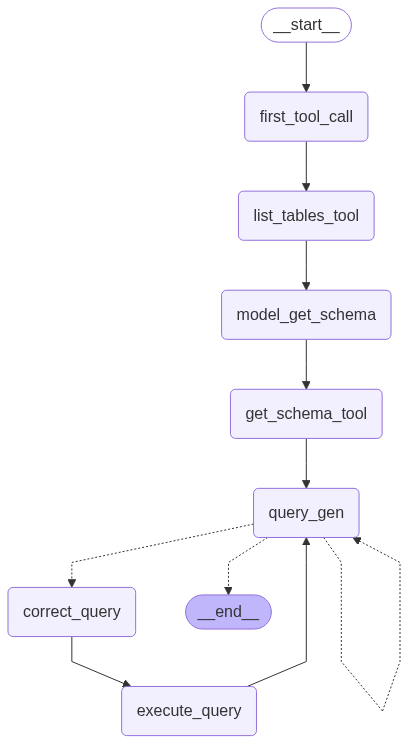

In [24]:
app

## Excution the Agent
Execute the agent to interact with an SQL database through the entire process.

The agent retrieves information from the database based on user queries, generates and executes SQL queries, and returns the results.

In [25]:
import uuid

def random_uuid():
    return str(uuid.uuid4())

def invoke_graph(app, inputs, config, node_names=None):
    # Logic to invoke the graph
    return app.invoke(inputs, config=config)

def stream_graph(app, inputs, config, node_names=None):
    # Logic to stream the graph
    for step in app.stream(inputs, config=config):
        yield step

In [26]:
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage
from langgraph.errors import GraphRecursionError

def run_graph(
    message: str, recursive_limit: int = 30, node_names=[], stream: bool = False
):
    
    # Configure settings (maximum recursion depth, thread ID)
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random_uuid()}
    )

    # Input the user's query
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    try:
        if stream:
            # Execute the graph with streaming
            stream_graph(app, inputs, config, node_names=node_names)
        else:
            # Execute the graph without streaming
            invoke_graph(app, inputs, config, node_names=node_names)
        # Retrieve and return the output state values
        output = app.get_state(config).values
        return output
    except GraphRecursionError as recursion_error:
        print(f"GraphRecursionError: {recursion_error}")
        # Return output state values even in case of a recursion error
        output = app.get_state(config).values
        return output

In [27]:
output = run_graph(
    "Let me know all personal information about employee Andrew Adam.",
    stream=False,
)

================================== Ai Message ==================================

Answer: Andrew Adams is a General Manager with the following personal information:

- **Employee ID**: 1
- **Birth Date**: February 18, 1962
- **Hire Date**: August 14, 2002
- **Address**: 11120 Jasper Ave NW, Edmonton, AB, Canada, Postal Code: T5K 2N1
- **Phone**: +1 (780) 428-9482
- **Fax**: +1 (780) 428-3457
- **Email**: andrew@chinookcorp.com


## Evaluating an SQL Agent Using LangFuse
Now, let's evaluate the SQL Agent's responses to queries. To do this, we'll first create a dataset specifically designed for evaluation purposes.

Next, we define an evaluator and proceed with the evaluation process.

For this, we use LLM-as-judge as the evaluator. The prompt employed will be the default one provided by the evaluation prompt hub.

However, for more precise evaluations, it is recommended to fine-tune the prompt to suit your specific needs.

In [28]:
import os
from langfuse import Langfuse
from langfuse.callback import CallbackHandler
from langchain.agents import create_sql_agent, AgentType
from langchain_core.runnables import RunnableConfig
from langchain import hub
from langfuse.decorators import observe
from uuid import uuid4 as random_uuid
from langchain_core.messages import HumanMessage

In [29]:
# Langfuse setup
langfuse = Langfuse(
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],  # Langfuse uses the same key for public/secret in some setups
    host=os.environ["LANGFUSE_HOST"]
)


agent_executor = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION
)

# Define LangGraph for SQL agent
def sql_node(state):
    query = state["messages"][-1].content
    result = agent_executor.run(query)
    return {"messages": state["messages"] + [HumanMessage(content=result)]}

In [31]:
examples = [
    (
        "Which country's customers spent the most? And how much did they spend?",
        "The country whose customers spent the most is the USA, with a total spending of 523.06.",
    ),
    (
        "What was the most purchased track of 2013?",
        "The most purchased track of 2013 was Hot Girl.",
    ),
    (
        "How many albums does the artist Led Zeppelin have?",
        "Led Zeppelin has 14 albums",
    ),
    (
        "What is the total price for the album “Big Ones”?",
        "The total price for the album 'Big Ones' is 14.85",
    ),
    (
        "Which sales agent made the most in sales in 2009?",
        "Steve Johnson made the most sales in 2009",
    ),
]

langfuse_handler = CallbackHandler(
    public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
    secret_key=os.environ["LANGFUSE_SECRET_KEY"],  # Langfuse uses the same key for public/secret in some setups
    host=os.environ["LANGFUSE_HOST"]
)

Next, we define a function to predict the SQL query response generated by our agent.

In [ ]:
# Function to predict SQL agent response with Langfuse tracing
@observe()
def predict_sql_agent_answer(example: dict):
    """Use this for answer evaluation with Langfuse tracing"""
    try:
        # Configure settings with thread_id for the checkpointer
        config = RunnableConfig(
            configurable={"thread_id": random_uuid()},
            recursion_limit=30,  # Match the limit from your run_graph function
            callbacks=[langfuse_handler]  # Include Langfuse handler
        )

        # Input the user's query
        inputs = {
            "messages": [HumanMessage(content=example["input"])],
        }

        # Execute the graph
        output = app.invoke(inputs, config)
        answer = output["messages"][-1].content
        
        return {"response": answer}
    except Exception as e:
        error_msg = f"Error: The agent failed to generate a response: {str(e)}"
        return {"response": error_msg}

Define the prompt and the evaluator (LLM-as-judge) to evaluate the SQL query response.

In [ ]:
# Define the answer evaluator (LLM-as-judge) with Langfuse tracing
@observe()
def answer_evaluator(prediction, example) -> dict:
    # Grade prompt for answer accuracy
    grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")
    
    answer_grader = grade_prompt_answer_accuracy | llm
    
    try:
        # Execute the evaluator
        score = answer_grader.invoke(
            {
                "question": example["input"],
                "correct_answer": example["output"],
                "student_answer": prediction["response"],
            }
        )
        score = score["Score"]
        
        return {"key": "answer_v_reference_score", "score": score}
    except Exception as e:
        return {"key": "answer_v_reference_score", "score": 0, "error": str(e)}

In [ ]:
# Perform evaluation with Langfuse tracing
@observe()
def evaluate_sql_agent():
    results = []
    
    try:
        for example in examples:
            # Predict the answer
            prediction = predict_sql_agent_answer({"input": example[0], "output": example[1]})
            
            # Evaluate the prediction
            eval_result = answer_evaluator(prediction, {"input": example[0], "output": example[1]})
            
            # Store results
            results.append({
                "input": example[0],
                "reference": example[1],
                "prediction": prediction["response"],
                "score": eval_result["score"]
            })
        
        return results
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return [{"error": str(e)}]

Now, we perform the evaluation and review the results.

In [32]:
# Run the evaluation
try:
    experiment_results = evaluate_sql_agent()
    
    for result in experiment_results:
        print(f"Question: {result['input']}")
        print(f"Reference: {result['reference']}")
        print(f"Prediction: {result['prediction']}")
        print(f"Score: {result['score']}")
        print("-" * 50)
    langfuse.flush()
except Exception as e:
    print(f"Error during evaluation: {str(e)}")

================================== Ai Message ==================================

SELECT BillingCountry, SUM(Total) AS TotalSpent
FROM Invoice
GROUP BY BillingCountry
ORDER BY TotalSpent DESC
LIMIT 1;
================================== Ai Message ==================================

Answer: The customers from the USA spent the most, with a total spending of $523.06.


d:\code\Langchain_Leaern\Tradence\SQL Agent\temp_temp_venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_TGmOx6DN3Fr15nVrAtsSVtP8)
 Call ID: call_TGmOx6DN3Fr15nVrAtsSVtP8
  Args:
    state: {'messages': [{'content': 'SELECT Track.Name, SUM(InvoiceLine.Quantity) AS TotalQuantity\nFROM InvoiceLine\nJOIN Track ON InvoiceLine.TrackId = Track.TrackId\nGROUP BY Track.Name\nORDER BY TotalQuantity DESC\nLIMIT 1;', 'type': 'ai'}]}
================================== Ai Message ==================================

SELECT Track.Name, SUM(InvoiceLine.Quantity) AS TotalQuantity
FROM InvoiceLine
JOIN Track ON InvoiceLine.TrackId = Track.TrackId
GROUP BY Track.Name
ORDER BY TotalQuantity DESC
LIMIT 1;
================================== Ai Message ==================================

Answer: The most purchased track of 2013 was "The Trooper".


d:\code\Langchain_Leaern\Tradence\SQL Agent\temp_temp_venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_wNB6WIOMGlfPFAjHADpUbhDL)
 Call ID: call_wNB6WIOMGlfPFAjHADpUbhDL
  Args:
    state: {'messages': [{'content': "SELECT COUNT(*) AS AlbumCount FROM Album INNER JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = 'Led Zeppelin';"}]}
================================== Ai Message ==================================

SELECT COUNT(*) AS AlbumCount FROM Album INNER JOIN Artist ON Album.ArtistId = Artist.ArtistId WHERE Artist.Name = 'Led Zeppelin';
================================== Ai Message ==================================

Answer: Led Zeppelin has 14 albums.


d:\code\Langchain_Leaern\Tradence\SQL Agent\temp_temp_venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================== Ai Message ==================================

SELECT SUM(UnitPrice * Quantity) AS Total_Price
FROM InvoiceLine
JOIN Track ON InvoiceLine.TrackId = Track.TrackId
JOIN Album ON Track.AlbumId = Album.AlbumId
WHERE Album.Title = 'Big Ones';
================================== Ai Message ==================================

Error: (sqlite3.OperationalError) ambiguous column name: UnitPrice
================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_eLTaGnjWt75wm6ZHR7wa6cAs)
 Call ID: call_eLTaGnjWt75wm6ZHR7wa6cAs
  Args:
    state: {'messages': [{'content': "SELECT SUM(InvoiceLine.UnitPrice * InvoiceLine.Quantity) AS Total_Price\nFROM InvoiceLine\nJOIN Track ON InvoiceLine.TrackId = Track.TrackId\nJOIN Album ON Track.AlbumId = Album.AlbumId\nWHERE Album.Title = 'Big Ones';"}]}
================================== Ai Message ==================================

SELECT SUM(InvoiceLine.UnitPrice * Invoice

d:\code\Langchain_Leaern\Tradence\SQL Agent\temp_temp_venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  model_check_query (call_mOGJNIFPrCKY8TOG04IHBNrG)
 Call ID: call_mOGJNIFPrCKY8TOG04IHBNrG
  Args:
    state: {'messages': [{'content': "SELECT e.FirstName, e.LastName, SUM(i.Total) as TotalSales FROM Employee e \nJOIN Customer c ON e.EmployeeId = c.SupportRepId \nJOIN Invoice i ON c.CustomerId = i.CustomerId \nWHERE strftime('%Y', i.InvoiceDate) = '2009' \nGROUP BY e.FirstName, e.LastName \nORDER BY TotalSales DESC LIMIT 1;", 'type': 'ai'}]}
================================== Ai Message ==================================

SELECT e.FirstName, e.LastName, SUM(i.Total) as TotalSales FROM Employee e 
JOIN Customer c ON e.EmployeeId = c.SupportRepId 
JOIN Invoice i ON c.CustomerId = i.CustomerId 
WHERE strftime('%Y', i.InvoiceDate) = '2009' 
GROUP BY e.FirstName, e.LastName 
ORDER BY TotalSales DESC LIMIT 1;
================================== Ai Message ==================================

Answer: 

d:\code\Langchain_Leaern\Tradence\SQL Agent\temp_temp_venv\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Question: Which country's customers spent the most? And how much did they spend?
Reference: The country whose customers spent the most is the USA, with a total spending of 523.06.
Prediction: Answer: The customers from the USA spent the most, with a total spending of $523.06.
Score: 1
--------------------------------------------------
Question: What was the most purchased track of 2013?
Reference: The most purchased track of 2013 was Hot Girl.
Prediction: Answer: The most purchased track of 2013 was "The Trooper".
Score: 0
--------------------------------------------------
Question: How many albums does the artist Led Zeppelin have?
Reference: Led Zeppelin has 14 albums
Prediction: Answer: Led Zeppelin has 14 albums.
Score: 1
--------------------------------------------------
Question: What is the total price for the album “Big Ones”?
Reference: The total price for the album 'Big Ones' is 14.85
Prediction: Answer: The total price for the album “Big Ones” is 9.9.
Score: 0
--------------